In [194]:
# this ai_utils version work only keras package (new 1.1.4 not is in pypi)
# from ai_utils.metrics import R_squared, fac2, pearson_r
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

## 1 - Global variables

In [280]:
# Global variables
ARGS = {
    "dataset_t": "confidential/train150.txt",
    "dataset_p": "confidential/prev150.txt",
    "headers": "confidential/headers.csv",
    "plot": "out/wind_speed_plot.png",
    "plot": "out/wind_speed_predict_plot.png",
}

In [264]:
# Load headers of dataset
HEADERS = pd.read_csv(ARGS["headers"], header=None).iloc[0]
display(HEADERS)

0            Dia
1            Mês
2            Ano
3           Hora
4     Velocidade
5        Direção
6    Temperatura
7        Umidade
8        Pressão
Name: 0, dtype: object

## 2 - Functions

### Third party functions [ai_utils](https://github.com/rcluan/ai_utils/blob/master/ai_utils/metrics/__init__.py)

In [265]:
def R_squared(y_true, y_pred):
    y_true_mean = y_true.mean()
    y_pred_mean = y_pred.mean()

    sum_num = np.sum((y_pred-y_pred_mean)*y_true)
    numerator = np.square(sum_num)

    ypm_square = np.square(y_pred - y_pred_mean)
    ytm_square = np.square(y_true - y_true_mean)
    denominator = np.sum(ypm_square) * np.sum(ytm_square)
    
    return numerator/denominator

In [266]:
def fac2(y_true, y_pred, to_numpy=False):
    min_ = 0.5
    max_ = 2

    division = tf.divide(y_pred, y_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    fac_2 = tf.reduce_mean(res)

    return K.get_value(fac_2) if to_numpy else fac_2


In [267]:
def pearson_r(y_true, y_pred):
    y_true_mean = y_true.mean()
    y_pred_mean = y_pred.mean()

    diff_yt = y_true - y_true_mean
    diff_yp = y_pred - y_pred_mean

    numerator = np.sum((diff_yt) * (diff_yp))
    denominator = np.sqrt(np.sum(np.square(diff_yt))) * np.sqrt(np.sum(np.square(diff_yp)))

    return numerator/denominator

---

In [281]:
# Function for multi plot
def _mplot(data_frame, x_values=None, x_title=None, w=16, h=12):
    # Get column count
    length = data_frame.shape[1]

    if x_values:
        x_values = data_frame.loc[:, x_values]
    else:
        x_values = data_frame.index
        
    _, axs = plt.subplots(length, 1, figsize=(w,h), sharex=True)
    for idx, column in enumerate(data_frame):
        axs[idx].plot(x_values, data_frame.loc[:, column], label=column)
        axs[idx].set_title(column)
        axs[idx].set_ylabel(column)
        axs[idx].legend()

    # adds space between plots
    plt.tight_layout()
    plt.xlabel(x_title)
    plt.show()

In [392]:
# Function for plot true and pred values
def _plot(true, pred, w=16, h=12, title="Previsão da velocidade média em Mucuri"):
    size = range(len(true))
    plt.figure(figsize=(w,h))
    plt.style.use("ggplot")
    plt.plot(size, true, linestyle="--", label="Anemômetro")
    plt.plot(size, pred, label="Rede Neural Artificial")
    plt.title(title)
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do vento (m/s)")
    plt.legend()
    plt.show()

In [273]:
# Function for show describe of dataset
def _describe(data_frame):
    def _apply(header, column):
        _max = column.max()
        _min = column.min()
        _count = column.count()

        return {
            "header": header,
            "max": _max,
            "min": _min,
            "mean": column.mean(),
            "median": column.median(),
            "1-quartile": column.quantile(0.25),
            "3-quartile": column.quantile(0.75),
            "var": column.var(),
            "std": column.std(),
            "mad": column.mad(),
            "amp": _max - _min,
            "rms": sum((column.pow(2)) / (_count)) ** (1 / 2),
            "kurtosis": column.kurtosis(),
            "skew": column.skew(),
            "count": _count,
            "nans": np.where(np.isnan(column))
        }

    headers = data_frame.columns
    return pd.DataFrame(
        [_apply(_, data_frame.loc[:, _]) for _ in headers]
    ).set_index("header")

In [274]:
# Function for evaluating prediction
def _evaluate(y_true, y_pred, index):
    return pd.DataFrame([{
        "r_squared": R_squared(y_true, y_pred),
        "fac_2": fac2(y_true, y_pred, to_numpy=True),
        "pearson_r": pearson_r(y_true, y_pred),
        "mae": mae(y_true, y_pred),
        "mse": mse(y_true, y_pred),
        "min_error": np.amin(np.absolute(y_true - y_pred)),
        "max_error": np.amax(np.absolute(y_true - y_pred)),
    }], index=[index])

---

## 3 - Training and Validation

### 3.1 - Load and decription of datas

In [286]:
# Load train datas
df_t = pd.read_csv(
    ARGS["dataset_t"], delimiter="\t", header=None, names=HEADERS
)
display(df_t)

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500
5,30,11,2015,19,10.324444,51.320714,24.764706,83.344444,1021.286500
6,30,11,2015,20,9.862778,47.354507,24.310811,88.044643,1021.627500
7,30,11,2015,21,9.598889,41.816108,24.304348,91.329670,1021.892333
8,30,11,2015,22,9.488889,39.561270,24.500000,92.415385,1021.856167
9,30,11,2015,23,7.502222,37.881537,24.419355,93.629630,1021.834667


In [9]:
# Sow train data description (exists one nan value in temperatura = line 351)
_describe(df_t.loc[:, "Velocidade":])

,1-quartile,3-quartile,amp,count,kurtosis,mad,max,mean,median,min,nans,rms,skew,std,var
header,,,,,,,,,,,,,,,
Velocidade,6.215278,10.146806,12.360317,550,-0.604439,2.226815,13.572222,8.176719,8.320000,1.211905,"([],)",8.618050,-0.116473,2.724988,7.425558
Direção,38.605367,83.329498,355.105536,550,10.090187,36.885553,356.553715,73.027647,59.019307,1.448179,"([],)",97.723439,3.102942,64.996263,4224.514238
Temperatura,23.314815,25.359375,9.524346,549,0.816960,1.287227,30.140625,24.443445,24.336134,20.616279,"([351],)",NaN,0.680716,1.669638,2.787691
Umidade,80.942222,91.434531,51.644444,550,2.131210,6.592405,98.000000,85.263578,86.765805,46.355556,"([],)",85.693365,-1.253161,8.579562,73.608878
Pressão,1016.544542,1021.497917,86.192167,550,22.104152,5.065583,1023.726500,1017.313986,1020.046750,937.534333,"([],)",1017.351944,-4.065313,8.796185,77.372876


In [287]:
# Interpolates train data due nans values
df_t = df_t.interpolate('cubic')
_describe(df_t.loc[:, "Velocidade":])

,1-quartile,3-quartile,amp,count,kurtosis,mad,max,mean,median,min,nans,rms,skew,std,var
header,,,,,,,,,,,,,,,
Velocidade,6.215278,10.146806,12.360317,550,-0.604439,2.226815,13.572222,8.176719,8.320000,1.211905,"([],)",8.618050,-0.116473,2.724988,7.425558
Direção,38.605367,83.329498,355.105536,550,10.090187,36.885553,356.553715,73.027647,59.019307,1.448179,"([],)",97.723439,3.102942,64.996263,4224.514238
Temperatura,23.315657,25.359083,9.524346,550,0.824349,1.285328,30.140625,24.442972,24.334734,20.616279,"([],)",24.499726,0.682133,1.668153,2.782736
Umidade,80.942222,91.434531,51.644444,550,2.131210,6.592405,98.000000,85.263578,86.765805,46.355556,"([],)",85.693365,-1.253161,8.579562,73.608878
Pressão,1016.544542,1021.497917,86.192167,550,22.104152,5.065583,1023.726500,1017.313986,1020.046750,937.534333,"([],)",1017.351944,-4.065313,8.796185,77.372876


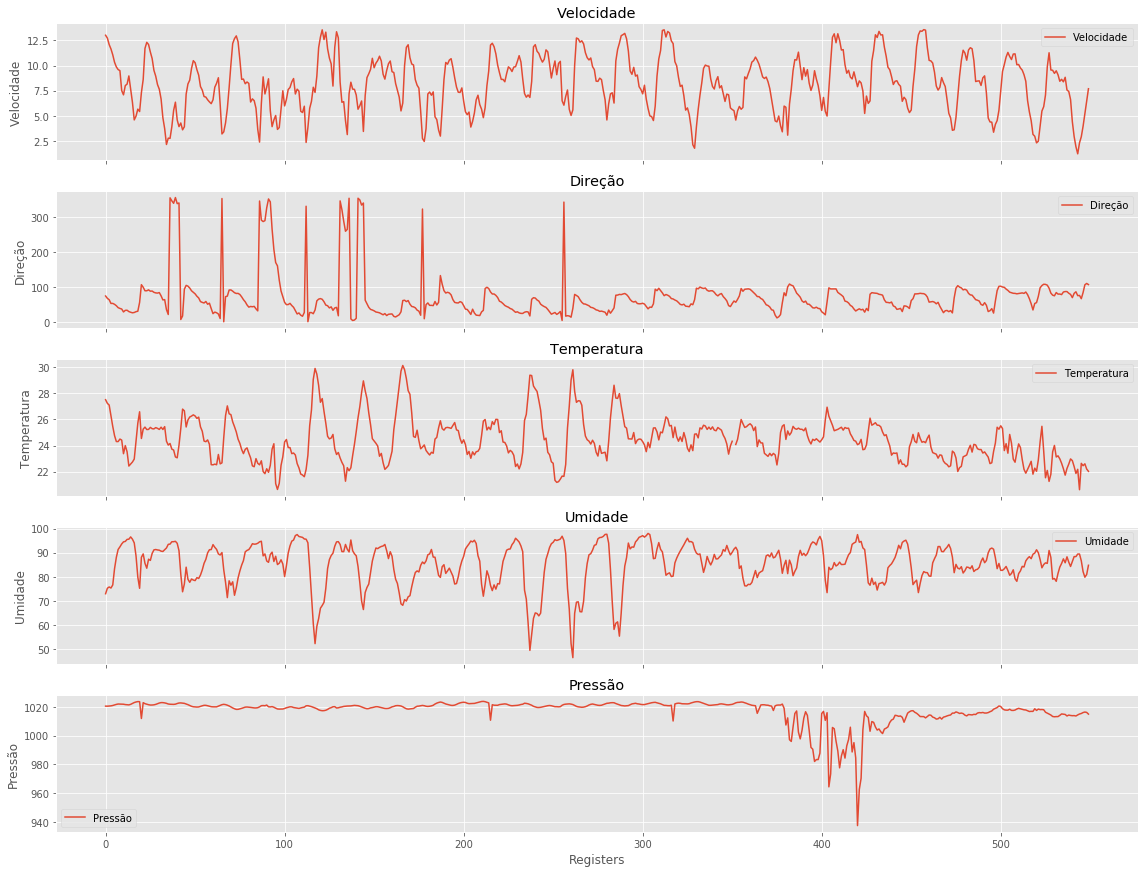

In [276]:
# Plot train datas
_mplot(df_t.loc[:, "Velocidade":], x_title="Registers")

---

### 3.2 - Split and normalize of datas

In [12]:
# Dataset for execution of the train and validation
x = df_t.iloc[:-1]
y = df_t.iloc[1:, 4]

In [13]:
# Partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(x_train, x_test, y_train, y_test) = train_test_split(
    x, y, test_size=0.25, random_state=42
)

In [14]:
# Normalize vector x
x_scaler = preprocessing.MinMaxScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

In [15]:
# Normalize vector y
y_scaler = preprocessing.MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

---

### 3.3 - Define and training the model

In [16]:
# Define the 9-9-6-1 architecture using tf.keras
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(9, input_shape=(9,), activation="tanh"))
model.add(tf.keras.layers.Dense(9, activation="tanh"))
model.add(tf.keras.layers.Dense(6, activation="tanh"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

Instructions for updating:
Colocations handled automatically by placer.


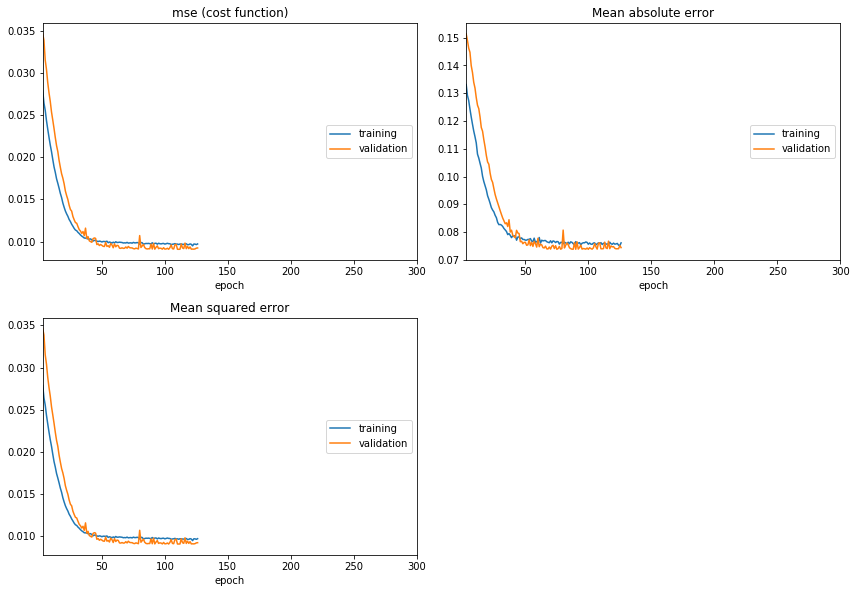

mse (cost function):
training   (min:    0.009, max:    0.040, cur:    0.010)
validation (min:    0.009, max:    0.039, cur:    0.009)

Mean absolute error:
training   (min:    0.075, max:    0.159, cur:    0.076)
validation (min:    0.074, max:    0.158, cur:    0.074)

Mean squared error:
training   (min:    0.009, max:    0.040, cur:    0.010)
validation (min:    0.009, max:    0.039, cur:    0.009)
411/411 [==============================] - 2s 5ms/sample - loss: 0.0097 - mean_absolute_error: 0.0761 - mean_squared_error: 0.0097 - val_loss: 0.0092 - val_mean_absolute_error: 0.0744 - val_mean_squared_error: 0.0092


In [17]:
# Initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.001
EPOCHS = 300
BATCH_SIZE = 1

# Compile the model using SGD as our optimizer, mae and mse
opt = tf.keras.optimizers.SGD(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mse"])

# Train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(patience=15),
        PlotLossesCallback()
    ]
)

---

In [18]:
# Evaluate the model (MSE and MAE)
scores = model.evaluate(x_test, y_test)
for s in range(len(scores)):
    print(f"{model.metrics_names[s]}: {scores[s]}")

138/138 [==============================] - 0s 54us/sample - loss: 0.0092 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0092
loss: 0.009242777510181717
mean_absolute_error: 0.074405238032341
mean_squared_error: 0.009242777712643147


---

## 4 - Forecasting and Evaluation

### 4.1 - Load and decription of datas

In [231]:
# Load pred datas
df_p = pd.read_csv(
    ARGS["dataset_p"], delimiter="\t", header=None, names=HEADERS
)
display(df_p)

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,23,12,2015,12,12.242778,77.442821,21.516779,87.861111,1014.845833
1,23,12,2015,13,9.268333,73.171002,23.075269,73.338889,1014.793333
2,23,12,2015,14,8.734444,96.238878,22.545455,78.533333,1014.085333
3,23,12,2015,15,9.662222,110.156291,21.459770,83.722222,1013.541500
4,23,12,2015,16,8.620556,97.686662,22.133803,84.691275,1013.563333
5,23,12,2015,17,8.762222,89.671248,22.825806,85.358974,1012.883500
6,23,12,2015,18,8.967778,86.459283,22.772277,85.947712,1012.747333
7,23,12,2015,19,9.321667,80.105866,23.250000,83.649718,1012.658000
8,23,12,2015,20,9.608333,81.595624,23.375000,85.320896,1013.107333
9,23,12,2015,21,9.172778,72.847974,23.636364,85.841060,1012.802667


In [220]:
# Sow train data description
_describe(df_p.loc[:, "Velocidade":])

,1-quartile,3-quartile,amp,count,kurtosis,mad,max,mean,median,min,nans,rms,skew,std,var
header,,,,,,,,,,,,,,,
Velocidade,6.498889,10.404306,14.101984,744,-0.583534,2.245532,15.313889,8.440594,8.489167,1.211905,"([],)",8.878071,-0.064374,2.754399,7.586714
Direção,39.725962,83.353583,355.105536,744,12.907184,32.925486,356.553715,70.913340,59.891964,1.448179,"([],)",92.131620,3.402864,58.857368,3464.189743
Temperatura,23.356368,25.370910,11.204455,744,1.080181,1.230401,30.140625,24.390728,24.309817,18.936170,"([],)",24.442564,0.538987,1.592086,2.534736
Umidade,81.606481,91.520952,52.355288,744,2.108927,6.349837,98.710843,85.680048,87.350906,46.355556,"([],)",86.077218,-1.237156,8.264904,68.308641
Pressão,1014.022208,1021.024417,86.192167,744,23.052438,5.070307,1023.726500,1016.543352,1019.163250,937.534333,"([],)",1016.574524,-3.844125,7.966256,63.461228


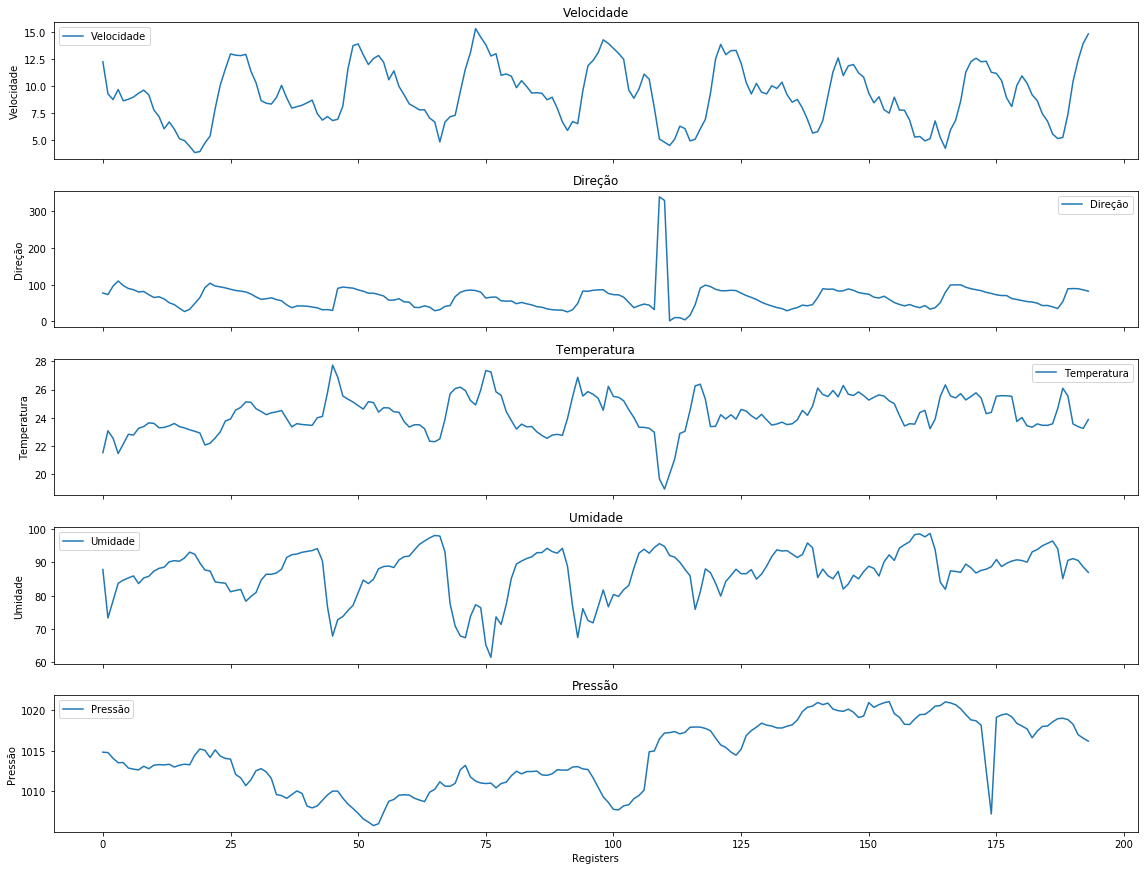

In [21]:
# Plot pred datas
_mplot(df_p.loc[:, "Velocidade":], x_title="Registers")

---

In [288]:
# Concat df_t with df_p
df = pd.concat([df_t, df_p], ignore_index=True)
display(df)

,Dia,Mês,Ano,Hora,Velocidade,Direção,Temperatura,Umidade,Pressão
0,30,11,2015,14,13.012139,75.105481,27.516129,72.930636,1020.422601
1,30,11,2015,15,12.726087,68.334332,27.238095,75.212121,1020.394348
2,30,11,2015,16,12.081111,64.457865,27.105263,75.741379,1020.508333
3,30,11,2015,17,11.647222,53.842100,26.305556,75.302632,1020.611000
4,30,11,2015,18,11.064444,53.945279,25.464286,76.592593,1020.866500
5,30,11,2015,19,10.324444,51.320714,24.764706,83.344444,1021.286500
6,30,11,2015,20,9.862778,47.354507,24.310811,88.044643,1021.627500
7,30,11,2015,21,9.598889,41.816108,24.304348,91.329670,1021.892333
8,30,11,2015,22,9.488889,39.561270,24.500000,92.415385,1021.856167
9,30,11,2015,23,7.502222,37.881537,24.419355,93.629630,1021.834667


---

### 4.2 - Split and normalize of datas

In [385]:
# Dataset for execution of the prediction
x_true = df.iloc[:-1]
y_true = df.iloc[1:, 4]

In [386]:
# Normalize x_true
x_true = x_scaler.transform(x_true)

---

### 4.3 - Forecasting and evaluation

#### 4.3.1 - Forecasting for 1hour

In [387]:
# Forecasting for 1 hour
preds = model.predict(x_true)

In [388]:
# Reverse normalization
y_pred = y_scaler.inverse_transform(preds)

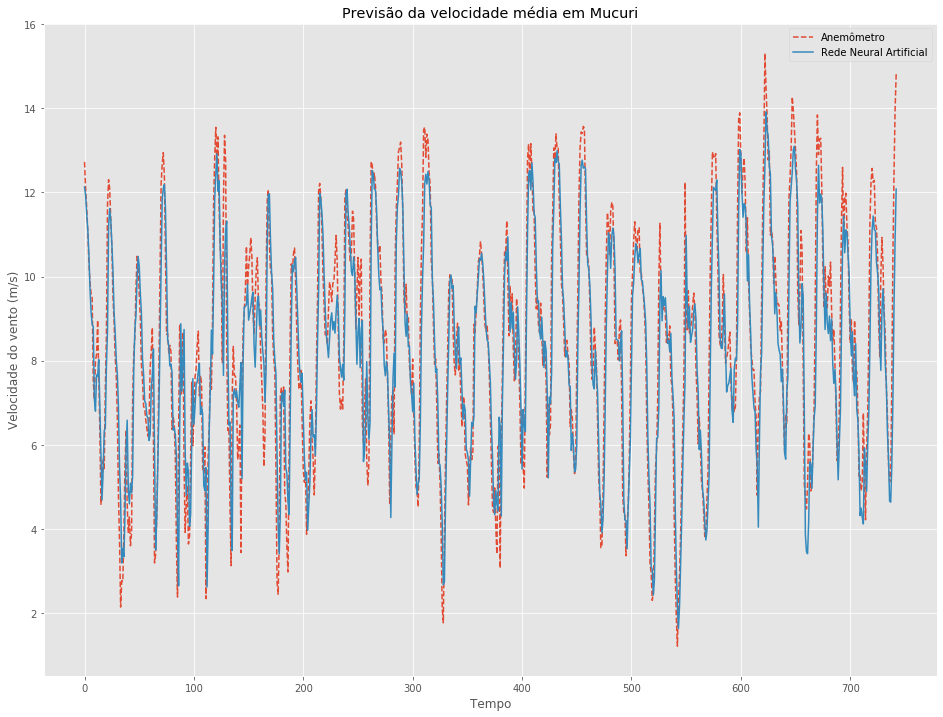

In [389]:
# Plot true and forecasting values
_plot(y_true, y_pred)

In [390]:
# Evaluate values for 1hour
evaluate = _evaluate(
    y_true.values,
    y_pred.reshape(1,-1)[0],
    "1-hour(s)"
)
display(evaluate)

,fac_2,mae,max_error,min_error,mse,pearson_r,r_squared
1-hour(s),0.990579,0.907796,4.715399,0.003796,1.393934,0.906447,0.821646


---

#### 4.3.2 Forecating with inference for 3, 6, 9, 12, 18, 24

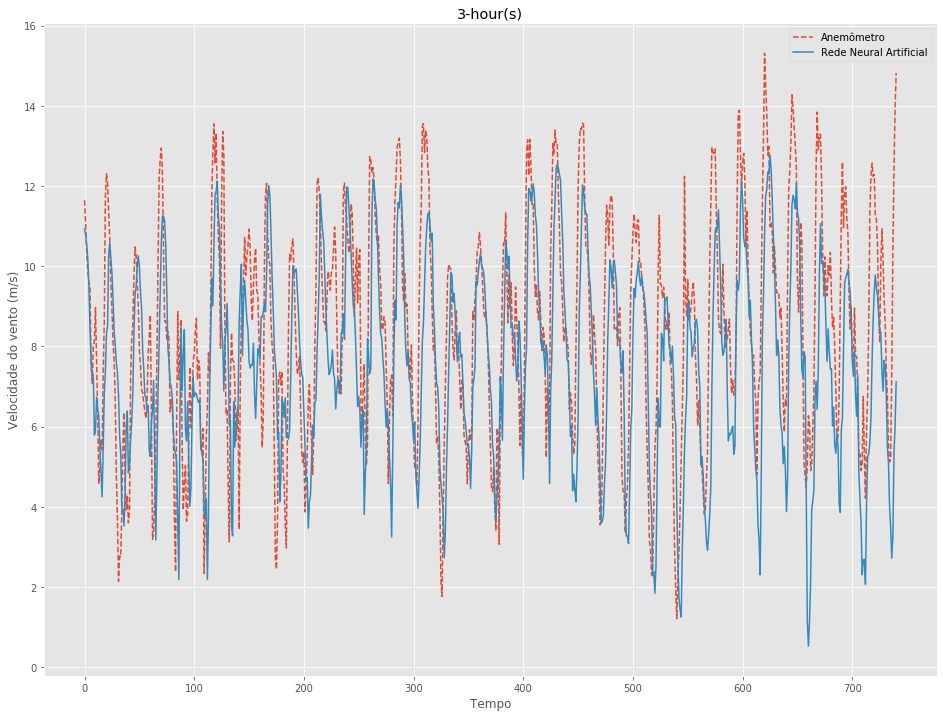

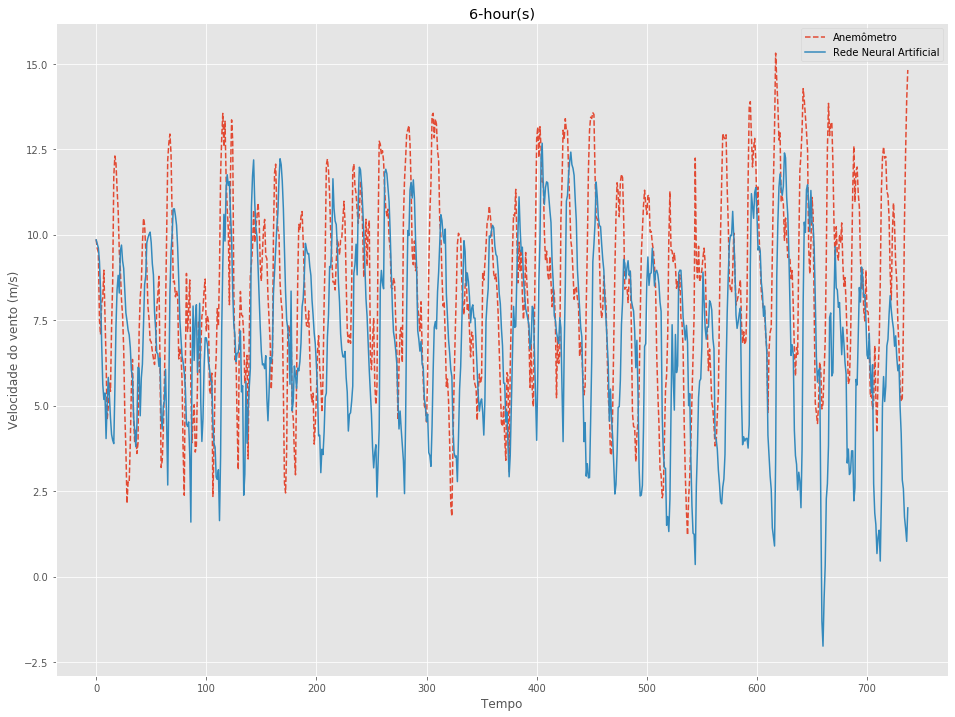

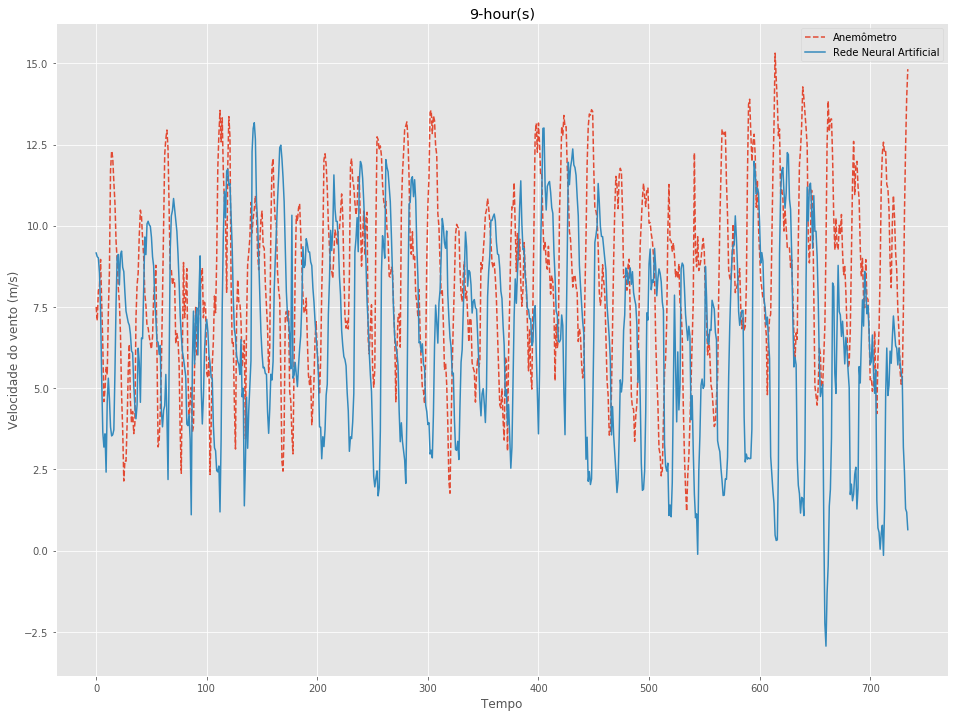

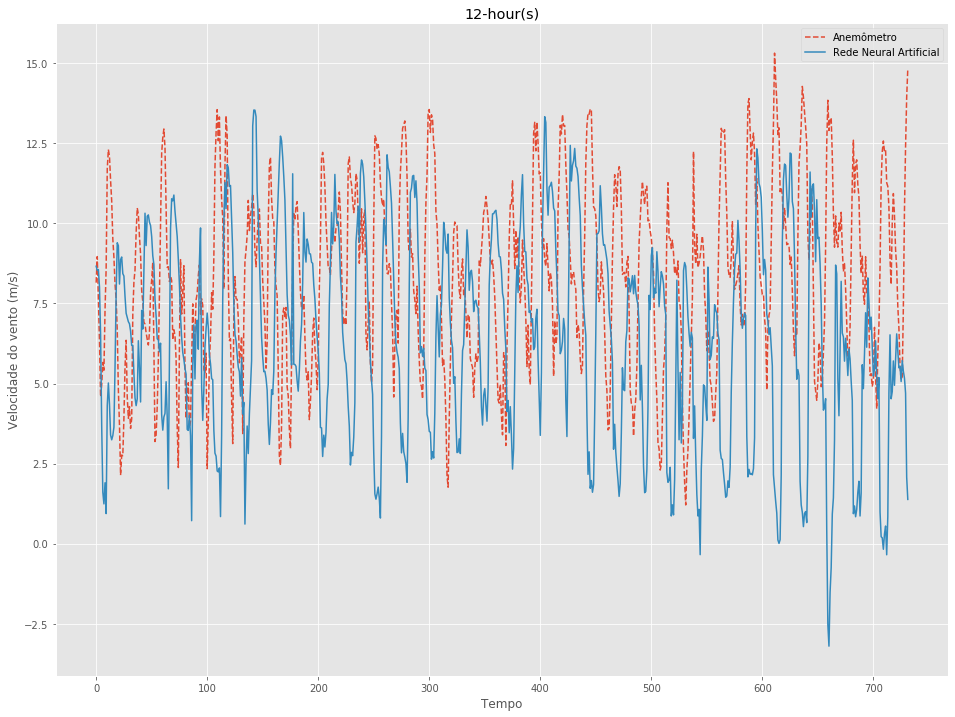

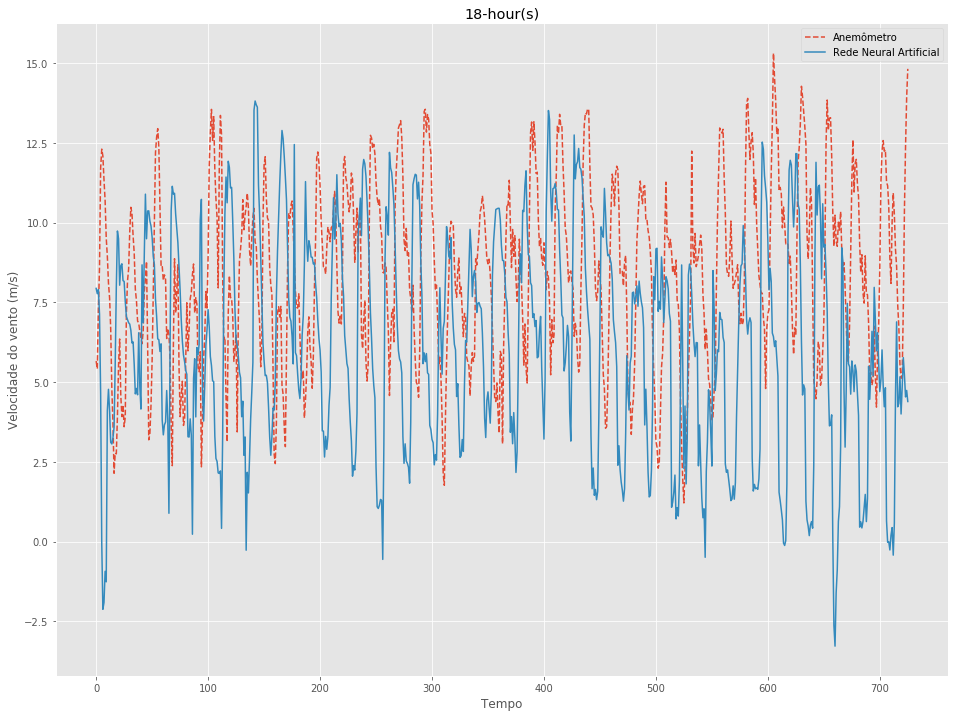

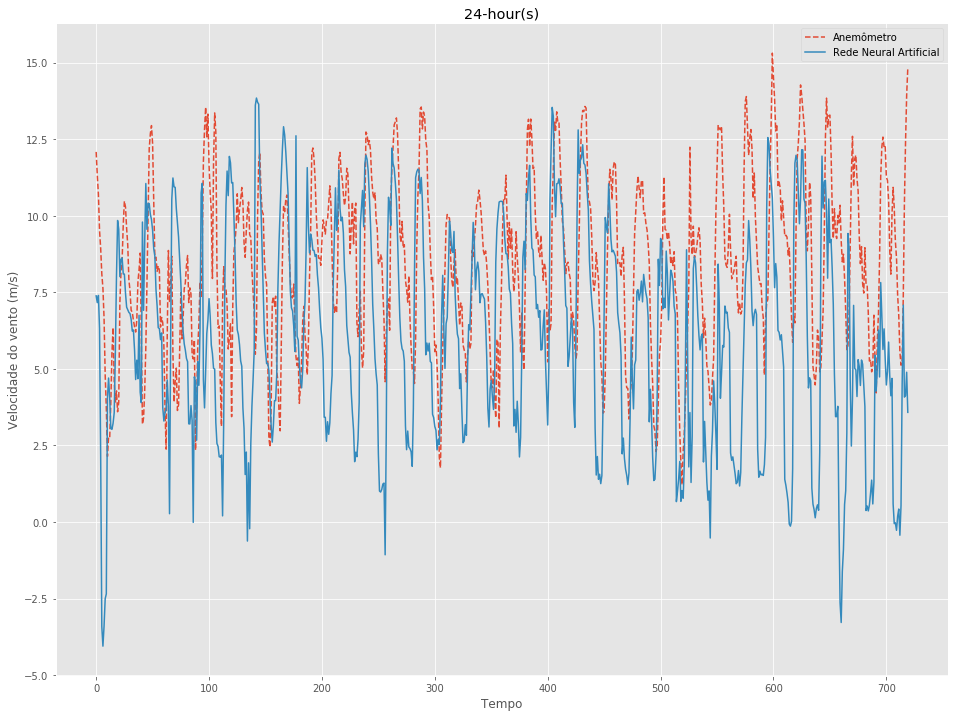

In [393]:
# Forecating with inference for 3, 6, 9, 12, 18, 24
inferences = (3, 6, 9, 12, 18, 24)
for i in inferences:
    # Dataset for execution of the prediction
    x_true = df.iloc[:-i]
    y_true = df.iloc[i:, 4]
    
    # Normalize x_true
    x_true = x_scaler.transform(x_true)

    # TODO: Refactor for
    y_pred = []
    for idx in range(x_true.shape[0]):
        l_pred = x_true[idx:idx+1]
        
        # Forecasting by inference
        for _ in range(i):
            preds = model.predict(l_pred)
            l_pred[0,4] = preds
        
        # Adds preds in pred list
        y_pred.append(preds[0])

    # Reverse normalization
    y_pred = y_scaler.inverse_transform(y_pred)
    
    # Plot true and forecasting values
    _plot(y_true, y_pred, title=f"{i}-hour(s)")
    
    # Evaluate values for ihour
    evaluate = pd.concat([
        evaluate, 
        _evaluate(
            y_true.values,
            y_pred.reshape(1,-1)[0],
            f"{i}-hour(s)"
        )
    ])

In [394]:
# Show all evaluates
display(evaluate)

,fac_2,mae,max_error,min_error,mse,pearson_r,r_squared
1-hour(s),0.990579,0.907796,4.715399,0.003796,1.393934,0.906447,0.821646
3-hour(s),0.931174,1.773025,7.954530,0.003322,5.299239,0.666592,0.444345
6-hour(s),0.808943,2.714211,12.915626,0.004066,13.262499,0.263052,0.069196
9-hour(s),0.712925,3.586886,14.837515,0.017986,22.925846,-0.187317,0.035088
12-hour(s),0.639344,4.251291,16.366633,0.008205,29.480702,-0.449927,0.202434
18-hour(s),0.573003,4.637782,14.210626,0.002735,29.037761,-0.279548,0.078147
24-hour(s),0.679167,3.502013,12.980386,0.000167,18.017098,0.365228,0.133392
